In [1]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver as Solver

from IPython.core.display import HTML
with open( './style.css', 'r' ) as f: st = f.read()
HTML('<style>%s</style>' %st)

<div class="head1">
    <div class="head1__name">
        Custom solver
    </div>
</div>

In [2]:
def rk4(f, t_min, t_max, r0, n):
    h = 1. * (t_max - t_min) / n
    t = t_min
    r = r0

    for i in range(1, n + 1):
        k1 = h * f(r, t)
        k2 = h * f(r + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(r + k3, t + h)
        t+= h
        r+= (k1 + k2 + k2 + k3 + k3 + k4) / 6.
        
    return r

<div class="head1">
    <div class="head1__name">
        Test 1D
    </div>
</div>

In [3]:
def func_f0(r, t):
    return r*r

def func_rt(t, r0):
    return r0 / (1. - r0 * t)

t = 1.
r0 = -5.5 * np.arange(10)
   
r_real = func_rt(t, r0)
r_calc = rk4(func_f0, 0., t, r0, 1000)
e = np.max(np.abs(r_real - r_calc))
print('%-8.2e'%e)

1.61e-09


<div class="head1">
    <div class="head1__name">
        Test 2D
    </div>
</div>

Consider
$$
    d r = f(r, t) \, d t,
    \quad
    r = (r_1, r_2) \in R^{2},
    \quad
    r(0) = r_0,
$$

Let set analytic solution
$$
    r_1(t) = \sin{2 t^2} + r_{0, 1},
    \quad
    r_2(t) = \cos{2 t^2} + r_{0, 2} - 1.
$$
then for the rhs we have
$$
    f_1(r, t) = 4 t \cos{2 t^2} = 4 t (r_2 - r_{0, 2} + 1),
    \quad
    f_2(r, t) = - 4 t \sin{2 t^2} = - 4 t (r_1 - r_{0, 1}).
$$

In [17]:
def func_f0(r, t, r0_=None):
    if r0_ is None:
        r0_ = r0
    v1 = +4. * t * (r[1, :] - r0_[1, :] + 1.)
    v2 = -4. * t * (r[0, :] - r0_[0, :])
    return np.vstack([v1, v2])

def func_rt(t):
    v1 = np.sin(2. * t * t) + r0[0, :]
    v2 = np.cos(2. * t * t) + r0[1, :] - 1.
    return np.vstack([v1, v2])

t = 1.
r0 = np.vstack([
    np.arange(10) * 1.1,
    np.arange(10) * 1.5,
])

#r0 = np.array([[2.], [0.]])

<div class="head2">
    <div class="head2__name">
        Custom solver
    </div>
</div>

In [18]:
r_real = func_rt(t)
r_calc = rk4(func_f0, 0., t, r0, 10000)
e = np.max(np.abs(r_real - r_calc))
print('Error : %-8.2e'%e)

Error : 1.42e+00


<div class="head2">
    <div class="head2__name">
        Scipy solver
    </div>
</div>

In [19]:
r = np.zeros(r0.shape)
for j in range(r0.shape[1]):
    def func(t, r):
        f = func_f0(r.reshape(-1, 1), t, r0[:, j].reshape(-1, 1)).reshape(-1)
        return f

    y1 = r0[:, j]
    y2 = solve_ivp(func, [0., t], y1, method='RK45', min_step=t/10000).y[:, -1]
    r[:, j] = y2

r_calc = r
r_real = func_rt(t)

e = np.mean(np.abs((r_real - r_calc) / r_real))
print('Error : %-8.2e'%e)

Error : 1.05e-03


In [20]:
print(r_calc)
print(r_real)

[[ 2.9093826   4.00949594  5.11008378  6.21011656  7.31042346  8.41088384
   9.51145893 10.61213262 11.7128972  12.81374856]
 [-1.41724317  0.0823773   1.58108611  3.08145454  4.58153578  6.08147687
   7.5813399   9.08115892 10.58095562 12.08074522]]
[[ 2.9092974  4.0092974  5.1092974  6.2092974  7.3092974  8.4092974
   9.5092974 10.6092974 11.7092974 12.8092974]
 [-1.4164135  0.0835865  1.5835865  3.0835865  4.5835865  6.0835865
   7.5835865  9.0835865 10.5835865 12.0835865]]


In [10]:
solve_ivp?

Signature:
solve_ivp(
    ['fun', 't_span', 'y0', "method='RK45'", 't_eval=None', 'dense_output=False', 'events=None', 'vectorized=False', '**options'],
)
Docstring:
Solve an initial value problem for a system of ODEs.

This function numerically integrates a system of ordinary differential
equations given an initial value::

    dy / dt = f(t, y)
    y(t0) = y0

Here t is a one-dimensional independent variable (time), y(t) is an
n-dimensional vector-valued function (state), and an n-dimensional
vector-valued function f(t, y) determines the differential equations.
The goal is to find y(t) approximately satisfying the differential
equations, given an initial value y(t0)=y0.

Some of the solvers support integration in the complex domain, but note that
for stiff ODE solvers, the right-hand side must be complex-differentiable
(satisfy Cauchy-Riemann equations [11]_). To solve a problem in the complex
domain, pass y0 with a complex data type. Another option is always to
rewrite your problem 

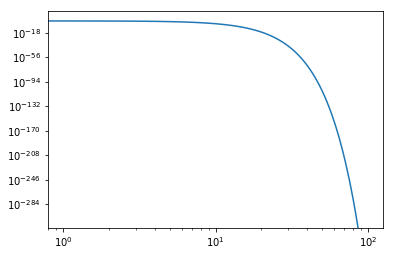

In [30]:
x = np.arange(100)
y = np.exp(-x*x/10)
plt.plot(x, y)
plt.semilogx()
plt.semilogy()
plt.show()

$$
    d x = f(x, t) \, d t,
    \quad
    x \in R^{1},
    \quad
    x_0 = [2],
    \quad
    f(x, t) = x^2,
$$
analytic solution
$$
    x(t) = \frac{x_0}{1 - x_0 t}.
$$

In [31]:
def func_f0(x, t):
    return x*x

def func_xt(t, x0):
    return x0 / (1. - x0 * t)

d = 1
t0 = 0.
t = 0.1

def func_x(t, v):
    x = v.reshape(d, -1)
    f0 = func_f0(x, t)
    res = f0
    return res

X0 = np.array([-1., -2., -3.]).reshape(1, -1)

X = np.zeros(X0.shape)
for j in range(X0.shape[1]):
    y1 = X0[:, j]
    y2 = solve_ivp(func_x, [t0, t], y1).y[:, -1]
    X[:, j] = y2

X_calc = X

X_real = np.zeros(X.shape)
for j in range(X0.shape[1]):
    X_real[:, j] = func_xt(t, X0[:, j])
    
e = np.mean(np.abs((X_real - X_calc) / X_real))
print(e)

2.6455192540951625e-07


In [10]:
def func_f0(x, t):
    e = np.ones(x.shape[1])
    v_1 = np.cos(t) * e
    v_2 = -np.sin(2. * t) * e
    return np.vstack([v_1, v_2])

def func_xt(t, x0):
    e = np.ones(x0.shape[1])
    v_1 = x0[0, :] + np.sin(t) * e 
    v_2 = x0[1, :] + np.cos(t)**2 * e - 1.
    return np.vstack([v_1, v_2])

def func(t, v):
    x = v.reshape(d, -1)
    f0 = func_f0(x, t)
    res = f0[:, 0]
    return res

d = 2
t = 1.

X0 = np.array([
    np.arange(10) * 1.4,
    np.arange(10) * 2.4,
])

X = np.zeros(X0.shape)
for j in range(X0.shape[1]):
    y1 = X0[:, j]
    y2 = solve_ivp(func, [0., t], y1).y[:, -1]
    X[:, j] = y2

X_calc = X
X_real = func_xt(t, X0)
e = np.mean(np.abs((X_real - X_calc) / X_real))
print(e)  

ValueError: `y0` must be 1-dimensional.

In [ ]:
from scipy.optimize import curve_fit

x = np.array([399.75, 989.25, 1578.75, 2168.25, 2757.75, 3347.25, 3936.75, 4526.25, 5115.75, 5705.25])
y = np.array([109,62,39,13,10,4,2,0,1,2])

def func(x, a, b, c, d):
    return a*np.exp(-c*(x-b))+d

popt, pcov = curve_fit(func, x, y, [100, 400, 0.001, 0])
print (popt)

plt.plot(x,y)
x = np.linspace(400,6000,10000)
plt.plot(x,func(x, *popt))
plt.show()

1.61e-09


In [17]:
r_calc

inf